In [1]:
from skimage import io
from skimage import transform
import numpy as np
io.use_plugin('matplotlib')
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def prepare_img(path):
    split_img = io.imread(path)
    uncutted_img = np.asarray([split_img[(i * split_img.shape[0]/3):((i + 1) * split_img.shape[0]/3) - (i+ 1)//3 ,:] for i in range(3)])
    img = np.asarray([uncutted_img[i][(uncutted_img[i].shape[0] * 0.07):(uncutted_img[i].shape[0] * 0.93), (uncutted_img[i].shape[1] * 0.07):(uncutted_img[i].shape[1] * 0.93)] for i in range(3)])
    return img

In [3]:
def mse(img1, img2):
    assert img1.shape == img2.shape
    return np.sum((img1 - img2)**2) / (img1.shape[0] * img1.shape[1])

def cross_cor(img1, img2) :
    return np.sum(img1 * img2) / np.sqrt(np.sum(img1 ** 2) * np.sum(img2 ** 2))

In [4]:
def shrink_to_fit(img1, img2):
    if img1.shape[0] > img2.shape[0]:
        img1 = img1[:img2.shape[0], :]
    else:
        img2 = img2[:img1.shape[0], :]
    if img1.shape[1] > img2.shape[1]:
        img1 = img1[:, :img2.shape[1]]
    else:
        img2 = img2[:, :img1.shape[1]]
    #print(img1.shape, img2.shape)
    assert img1.shape == img2.shape
    return img1, img2
        

In [5]:
def find_opt(img1, img2, mini=-15, maxi=15, minj=-15, maxj=15, metric='cross_cor', begin=True):
    if img1.shape != img2.shape:
        img1, img2 = shrink_to_fit(img1, img2)
    if metric == 'mse':
        opt = (mse(img1, img2), img1, img2, 0, 0, True)
    elif metric == 'cross_cor':
        opt = (-cross_cor(img1, img2), img1, img2, 0, 0, True)
    else:
        print('Unknown metric')
    for i in range(mini, maxi):
        for j in range(minj, maxj):
            I1 = img1
            I2 = img2
            if i > 0:
                I1 = I1[i:, :]
            elif i < 0:
                I2 = I2[-i:, :]
            if j > 0:
                I1 = I1[:, j:]
            elif j < 0:
                I2 = I2[:, -j:]
            I1, I2 = shrink_to_fit(I1, I2)
            if metric == 'mse':
                m = mse(I1, I2)
            elif metric == 'cross_cor':
                m = -cross_cor(I1, I2)
            if m < opt[0]:
                opt = (m, I1, I2, i, j)
    assert opt[1].shape == opt[2].shape
    return opt

In [6]:
def combine_channels(img):
    assert img[0].shape == img[1].shape == img[2].shape
    image = np.stack(np.array(img)[::-1], axis=-1)
    return image

def show_diff(img):
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    first_step = find_opt(img[0], img[1], metric='mse')
    second_step = find_opt(first_step[1], img[2], metric='mse')
    io.imshow(combine_channels(np.array([second_step[1],  first_step[2][second_step[3]:, second_step[4]:] if second_step[5] else first_step[2][:-second_step[3], :-second_step[4]], second_step[2]])))
    plt.subplot(1, 2, 2)
    first_step = find_opt(img[0], img[1], metric='cross_cor')
    second_step = find_opt(first_step[1], img[2], metric='cross_cor')
    io.imshow(combine_channels(np.array([second_step[1],  first_step[2][second_step[3]:, second_step[4]:] if second_step[5] else first_step[2][:-second_step[3], :-second_step[4]], second_step[2]])))
   

In [11]:
def prepare_pyramid(big):
    img = []
    img.append(big)
    less = np.array([transform.resize(big[i], (big[i].shape[0] / 2, big[i].shape[1] / 2)) for i in range(3)])
    while less[0].shape[0] >= 500:
        img.append(less)
        #less = np.array([transform.resize(less[i], (less[i].shape[0] / 2, less[i].shape[1] / 2)) for i in range(3)])
        less = np.array([less[i][::2, ::2] for i in range(3)])
    return img[::-1]

def pyramid(img_set, metric='cross_cor'):
    fmaxi = fmaxj = smaxi = smaxj = 20
    fmini = fminj = smini = sminj = -20
    for img in img_set:
        first_step = find_opt(img[0], img[1], fmini, fmaxi, fminj, fmaxj, metric=metric)
        second_step = find_opt(first_step[1], img[2], smini, smaxi, sminj, smaxj, metric=metric)
        fmini, fmaxi = first_step[3] * 2 - 1, first_step[3] * 2 + 1
        fminj, fmaxj = first_step[4] * 2 - 1, first_step[4] * 2 + 1
        smini, smaxi = second_step[3] * 2 - 1, second_step[3] * 2 + 1
        sminj, smaxj = second_step[4] * 2 - 1, second_step[4] * 2 + 1
    middle_channel = first_step[2]
    if second_step[3] > 0:
        middle_channel = middle_channel[second_step[3]:, :]
    elif second_step[3] < 0:
        middle_channel = middle_channel[-second_step[3]:, :]
    if second_step[4] > 0:
        middle_channel = middle_channel[:, second_step[4]:]
    elif second_step[4] < 0:
        middle_channel = middle_channel[:, -second_step[4]:]
    
    return combine_channels(np.array([second_step[1],  middle_channel, second_step[2]]))
    
def align(path):
    return pyramid(prepare_pyramid(prepare_img(path)))

/home/sonya/.local/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


CPU times: user 9.6 s, sys: 860 ms, total: 10.5 s
Wall time: 10.5 s


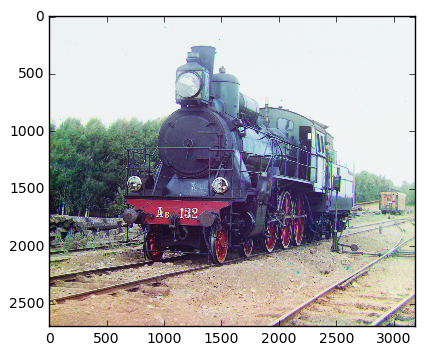

In [105]:
%time io.imshow(align('./big/00458a.png'))

/home/sonya/.local/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


CPU times: user 992 ms, sys: 0 ns, total: 992 ms
Wall time: 1.11 s


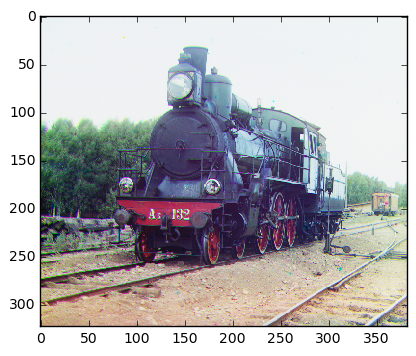

In [106]:
%time io.imshow(align('./small/00458a.png'))

/home/sonya/.local/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


CPU times: user 9.61 s, sys: 580 ms, total: 10.2 s
Wall time: 10.4 s


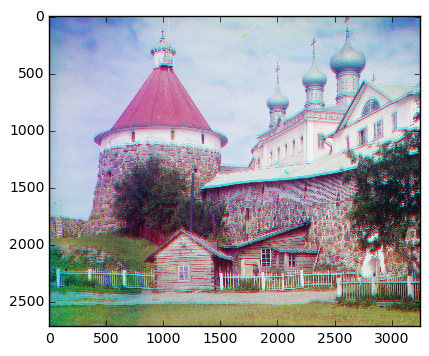

In [107]:
%time io.imshow(align('./big/00348a.png'))

/home/sonya/.local/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


CPU times: user 796 ms, sys: 0 ns, total: 796 ms
Wall time: 815 ms


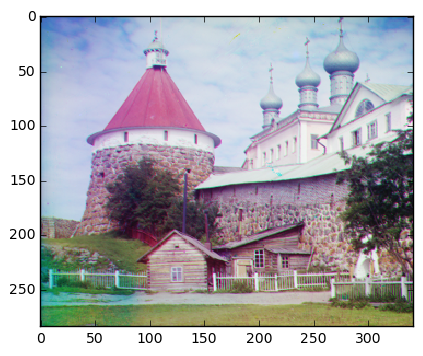

In [108]:
%time io.imshow(align('./small/00348a.png'))

/home/sonya/.local/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


CPU times: user 9.42 s, sys: 292 ms, total: 9.71 s
Wall time: 9.78 s


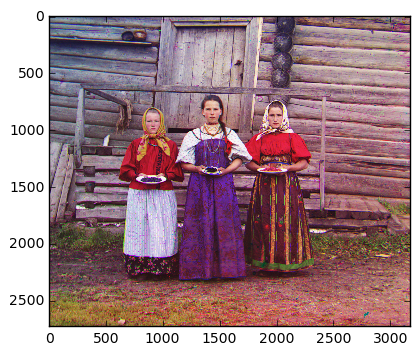

In [109]:
%time io.imshow(align('./big/01043a.png'))

/home/sonya/.local/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


CPU times: user 928 ms, sys: 12 ms, total: 940 ms
Wall time: 968 ms


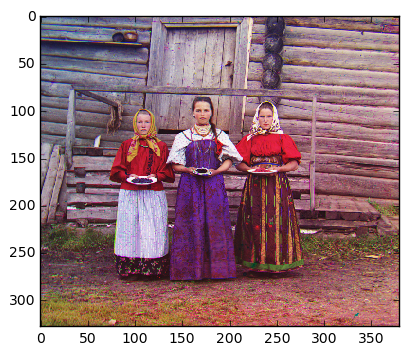

In [110]:
%time io.imshow(align('./small/01043a.png'))

/home/sonya/.local/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


CPU times: user 9.85 s, sys: 452 ms, total: 10.3 s
Wall time: 12.9 s


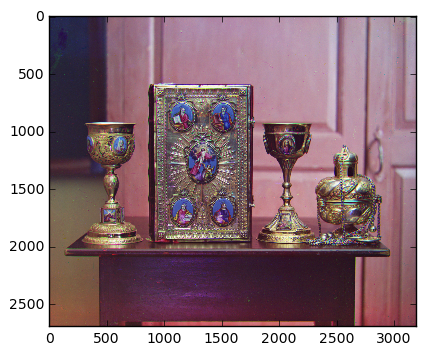

In [111]:
%time io.imshow(align('./big/01047a.png'))

/home/sonya/.local/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


CPU times: user 1.14 s, sys: 0 ns, total: 1.14 s
Wall time: 1.18 s


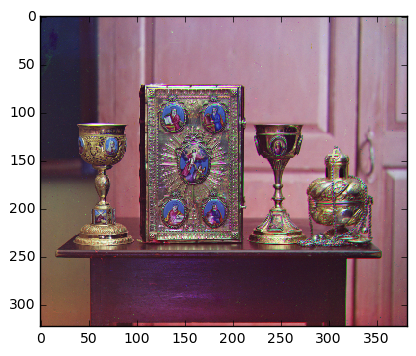

In [112]:
%time io.imshow(align('./small/01047a.png'))

/home/sonya/.local/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


CPU times: user 9.92 s, sys: 60 ms, total: 9.98 s
Wall time: 10 s


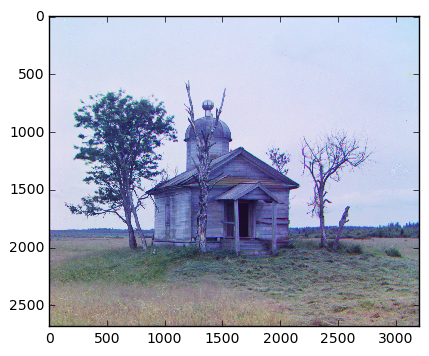

In [113]:
%time io.imshow(align('./big/01069a.png'))

/home/sonya/.local/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


CPU times: user 976 ms, sys: 0 ns, total: 976 ms
Wall time: 996 ms


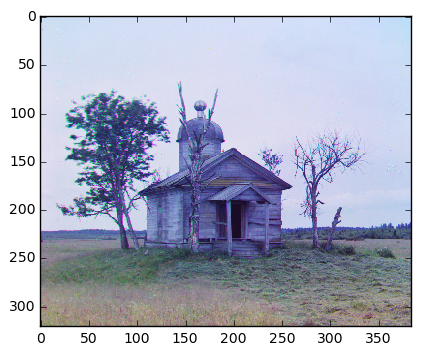

In [114]:
%time io.imshow(align('./small/01069a.png'))

/home/sonya/.local/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


CPU times: user 15.2 s, sys: 132 ms, total: 15.3 s
Wall time: 15.3 s


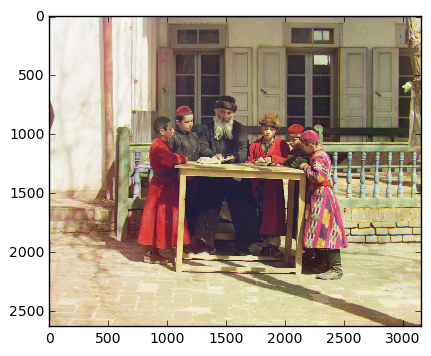

In [12]:
%time io.imshow(align('./big/01861a.png'))

/home/sonya/.local/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


CPU times: user 952 ms, sys: 0 ns, total: 952 ms
Wall time: 980 ms


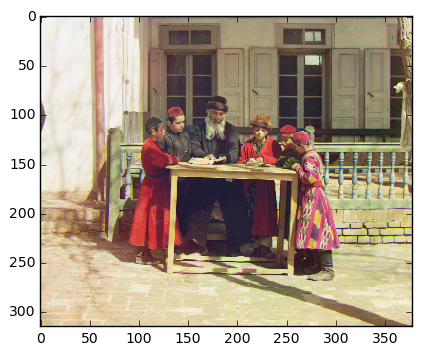

In [116]:
%time io.imshow(align('./small/01861a.png'))

/home/sonya/.local/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


CPU times: user 15.3 s, sys: 148 ms, total: 15.5 s
Wall time: 15.6 s


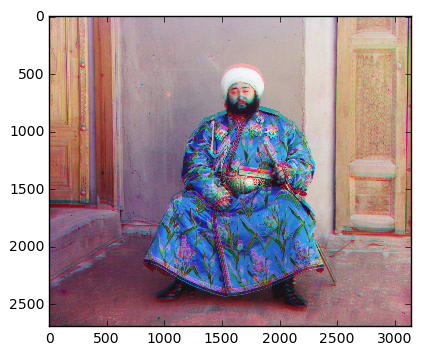

In [13]:
%time io.imshow(align('./big/01886a.png'))

/home/sonya/.local/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


CPU times: user 916 ms, sys: 0 ns, total: 916 ms
Wall time: 948 ms


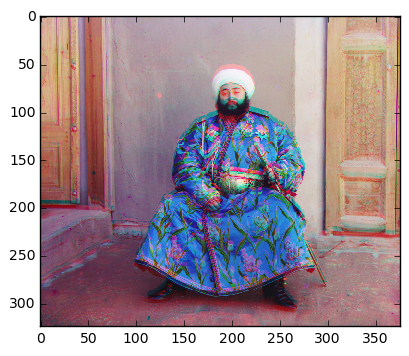

In [118]:
%time io.imshow(align('./small/01886a.png'))